# ILT of the difference

#### Import

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from jackknife import *
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.special import gamma
from corr_fits import *
from spectral_density import *
import mpmath

def u_s(s:float, w:float) -> complex:
    return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))

def I_n(n:int, w:float, s:np.array) -> complex:
    if isinstance(s, (float, int)):
        f = lambda x: np.exp(-w * x) * (x ** n) * u_s(s, x).conjugate()
        return quad(f, 0, +np.inf, complex_func=True)[0]
    else:
        res = np.zeros(len(s), dtype=complex)
        for i in range(len(s)):
            f = lambda x: np.exp(-w * x) * (x ** n) * u_s(s[i], x).conjugate()
            res[i] = quad(f, 0, +np.inf, complex_func=True)[0]
        return res
    #return gamma((n + 0.5 + s * 1.j)) * (w ** (-n)) * u_s(s, w).conjugate()

def mellin_C2(s:float, par:np.ndarray, n:int) -> complex:
    return par[0] * I_n(n, par[1], s) + par[2] * I_n(n, par[3], s)

def derI_dw(n:int, w:float, s:float) -> complex:
    if isinstance(s, (float, int)):
        f = lambda x: np.exp(-w * x) * (x ** (n+1)) * u_s(s, x).conjugate()
        return quad(f, 0, +np.inf, complex_func=True)[0]
    else:
        res = np.zeros(len(s), dtype=complex)
        for i in range(len(s)):
            f = lambda x: np.exp(-w * x) * (-x ** (n+1)) * u_s(s[i], x).conjugate()
            res[i] = quad(f, 0, +np.inf, complex_func=True)[0]
        return res
    #return -(n + 0.5 + s*1.0j) * I_n(n+1, w, s)

def jac_mellinC2(s:np.ndarray, par:np.ndarray, n:int) -> np.ndarray:
    if isinstance(s, (float, int)):
        return np.array([I_n(n, par[1], s), par[0] * derI_dw(n, par[1], s), I_n(n, par[3], s), par[2] * derI_dw(n, par[3], s)])
    else:
        J = np.zeros((len(par), len(s)), dtype=complex)
        for i in range(len(s)):
            J[:, i] = np.array([I_n(n, par[1], s[i]), par[0] * derI_dw(n, par[1], s[i]),\
                                     I_n(n, par[3], s[i]), par[2] * derI_dw(n, par[3], s[i])])
        return J

def mod_mellinC2(s:float, par:np.ndarray, n:int) -> complex:
    return np.sqrt(mellin_C2(s, par, n).real ** 2.0 + mellin_C2(s, par, n).imag ** 2.0)

def jac_modmellinC2(s:np.ndarray, par:np.ndarray, n:int) -> np.ndarray:
    J_c = jac_mellinC2(s, par, n)
    J = np.zeros(J_c.shape)

    if isinstance(s, (float, int)):
        return (mellin_C2(s, par, n).real * J_c.real + mellin_C2(s, par, n).imag * J_c.imag)/mod_mellinC2(s, par, n)
    for i in range(len(s)):
        J[:, i] = (mellin_C2(s[i], par, n).real * J_c[:, i].real + mellin_C2(s[i], par, n).imag * J_c[:, i].imag)/mod_mellinC2(s[i], par, n)

    return J

def interp(t:float, log_m:np.ndarray) -> float:
    if t >=1:
        return np.exp(np.interp(t, np.arange(1, 11), log_m))
    else:
        return np.exp(log_m[0])/t**3.0
    
def interp_cov(t1:float, t2:float, log_m:np.ndarray, log_cov:np.ndarray) -> float:
    i1, i2 = np.floor(t1), np.floor(t2)
    j1, j2 = np.zeros(len(log_m)), np.zeros(len(log_m))
    if t1 >=1:
        j1[int(i1) - 1], j1[int(i1)] = (1 + i1 - t1) * interp(t1, log_m), (t1 - i1) * interp(t1, log_m)
    else:
        j1[0] = 1/t1 ** 3.0
    if t2 >=1:
        j2[int(i2) - 1], j2[int(i2)] = (1 + i2 - t2) * interp(t2, log_m), (t2 - i2) * interp(t2, log_m)
    else:
        j2[0] = 1/t2 **3.0
    return j1.T @ log_cov @ j2

def mellin_diff(s:np.ndarray, n:float, log_m:np.ndarray) -> complex:
    if isinstance(s, (float, int)):
        #f_re = lambda t: (interp(t, log_m) * (t**n) * u_s(s, t)).real
        #f_im = lambda t: (interp(t, log_m) * (t**n) * u_s(s, t)).imag
        #return complex(quad(f_re, 1, 10)[0], quad(f_im, 1, 10)[0])
        sum = 0.0 + 0.0j
        for i in range(1, len(log_m)):
            dl = log_m[i-1] - log_m[i]
            sum += np.exp(log_m[i-1] + dl*i) * (dl ** -(n + 0.5 + s * 1.0j)) * complex(mpmath.gammainc(n + 0.5 + s*1.0j, i*dl, (i+1)*dl))
        return sum/np.sqrt(2*np.pi)
    else:
        r = np.zeros(len(s), dtype=complex)
        for i in range(len(s)):
            #f_re = lambda t: (interp(t, log_m) * (t**n) * u_s(s[i], t)).real
            #f_im = lambda t: (interp(t, log_m) * (t**n) * u_s(s[i], t)).imag
            #r[i] = complex(quad(f_re, 1, 10)[0], quad(f_im, 1, 10)[0])
            sum = 0.0 + 0.0j
            for k in range(1, len(log_m)):
                dl = log_m[k-1] - log_m[k]
                sum += np.exp(log_m[k-1] + dl*k) * (dl ** -(n + 0.5 + s[i] * 1.0j)) * complex(mpmath.gammainc(n + 0.5 + s[i]*1.0j, k*dl, (k+1)*dl))
            r[i] =  sum/np.sqrt(2*np.pi)
        return r

def f1(z, s, i, n, log_m):
    return np.exp(log_m[i-1]*(1-z) + log_m[i]*z) * (1-z) * ((z+i)**n) *u_s(s, z+i)

def f2(z, s, i, n, log_m):
    return np.exp(log_m[i-2]*(1-z) + log_m[i-1]*z) * z * ((z+i-1)**n) *u_s(s, z+i-1)

def jac_mellindiff(s:np.ndarray, n:float, log_m) -> complex:
    if isinstance(s, (float, int)):
        j = np.zeros((len(log_m), 1), dtype=complex)
        for i in range(1, len(j) + 1):
            if i == 1:
                f_re = lambda z: f1(z, s, i, n, log_m).real
                f_im = lambda z: f1(z, s, i, n, log_m).imag
            elif i == len(j):
                f_re = lambda z: f2(z, s, i, n, log_m).real
                f_im = lambda z: f2(z, s, i, n, log_m).imag
            else:
                f_re = lambda z: f1(z, s, i, n, log_m).real + f2(z, s[k], i, n, log_m).real
                f_im = lambda z: f1(z, s, i, n, log_m).imag + f2(z, s[k], i, n, log_m).imag
            j[i-1, k] = complex(quad(f_re, 0, 1)[0],  quad(f_im, 0, 1)[0])
        return j
    else:
        j = np.zeros((len(log_m), len(s)), dtype=complex)
        for k in range(len(s)):
            for i in range(1, len(j) + 1):
                if i == 1:
                    f_re = lambda z: f1(z, s[k], i, n, log_m).real
                    f_im = lambda z: f1(z, s[k], i, n, log_m).imag
                elif i == len(j):
                    f_re = lambda z: f2(z, s[k], i, n, log_m).real
                    f_im = lambda z: f2(z, s[k], i, n, log_m).imag
                else:
                    f_re = lambda z: f1(z, s[k], i, n, log_m).real + f2(z, s[k], i, n, log_m).real
                    f_im = lambda z: f1(z, s[k], i, n, log_m).imag + f2(z, s[k], i, n, log_m).imag
                j[i-1, k] = complex(quad(f_re, 0, 1)[0],  quad(f_im, 0, 1)[0])
        return j

def mod_mellindiff(s:float, n:int, log_m:np.ndarray) -> complex:
    return np.sqrt(mellin_diff(s, n, log_m).real ** 2.0 + mellin_diff(s, n, log_m).imag ** 2.0)

def jac_modmellindiff(s:np.ndarray, n:int, log_m:np.ndarray) -> np.ndarray:
    J_c = jac_mellindiff(s, n, log_m)
    J = np.zeros(J_c.shape)

    if isinstance(s, (float, int)):
        return (mellin_diff(s, n, log_m).real * J_c.real + mellin_diff(s, n, log_m).imag * J_c.imag)/mod_mellindiff(s, n, log_m)
    for i in range(len(s)):
        J[:, i] = (mellin_diff(s[i], n, log_m).real * J_c[:, i].real + mellin_diff(s[i], n, log_m).imag * J_c[:, i].imag)/mod_mellindiff(s[i], n, log_m)

    return J

## Jackknife method

### Computation of the difference between data and the fit

We want to compute the difference of the original correlator and the extrapolation from the double exponential fit. We nee to take into consideration the correlation of the data, which, through the parameters of the fit, propagates to the extrapolated data. We use the Jackknife method.

In [4]:
df = open("out/vector/data/correlators/run_vector_folded_ml_4.txt", "r")
jf = open("out/vector/data/correlators/run_vector_jack.txt", "r")

dat = df.readlines()

corr_jack = []

for line in dat:
    jack = np.zeros(25)
    for i in range(25):
        jack[i]  = float(jf.readline())
    corr_jack.append(Jackknife())
    corr_jack[-1].mean = float((line.split())[0])
    corr_jack[-1].jack = jack

corr, err_corr, cov_corr = Jackknife.to_lists(corr_jack)
        
df.close()
jf.close()

In [5]:
def double_exp_fit(t, c0, m0, c1, m1):
    return c0 * np.exp(-m0 * t) + c1 * np.exp(-t * m1)
    
def double_exp(t, par):
    return double_exp_fit(t, par[0], par[1], par[2], par[3])

par_jack = Jackknife.fit(double_exp_fit, np.arange(10, 35), corr_jack[10:35], [0.02, 0.2, 0.02, 0.5])

diff_jack = []
for i in range(len(corr)):
    f = lambda x: double_exp(i, x)
    diff_jack.append(corr_jack[i] - Jackknife.der_function(f, par_jack))

diff_jack = diff_jack[1:]
diff_m, diff_err, diff_cov = Jackknife.to_lists(diff_jack)

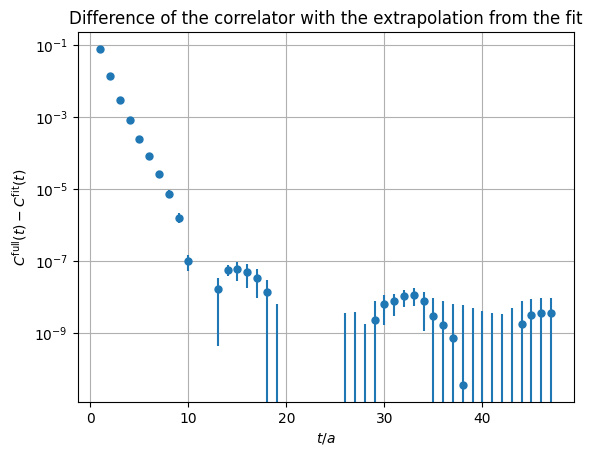

In [6]:
plt.errorbar(np.arange(1, len(diff_m[:])+1), diff_m[:], diff_err[:], fmt="o", markersize = 5)
plt.semilogy()
plt.grid()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$C^\mathrm{full}(t) - C^\mathrm{fit}(t)$")
plt.title("Difference of the correlator with the extrapolation from the fit")
plt.show()

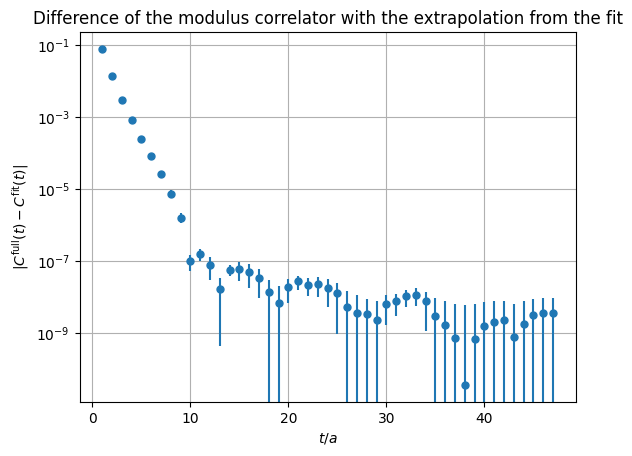

In [7]:
plt.errorbar(np.arange(1, len(diff_m[:])+1), np.abs(diff_m[:]), diff_err[:], fmt="o", markersize = 5)
plt.semilogy()
plt.grid()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$|C^\mathrm{full}(t) - C^\mathrm{fit}(t)|$")
plt.title("Difference of the modulus correlator with the extrapolation from the fit")
plt.show()

### Numeric ILT of the difference

We can now compute the ILT of these data. We will compare these results with the ones obtained by directly subtracting the spectral density. By linearity of the ILT, we should obtain the same results. So we compare the errors, to see if they are the same.

In [5]:
d = Double_exp()
corr_fit_jack = []
for i in range(len(corr_jack)):    
    f = lambda par: float(d.f(i, par))
    corr_fit_jack.append(Jackknife.der_function(f, par_jack))

In [8]:
alpha = [1e-6, 1e-9, 1e-12]
sigma = np.array([0.25, 0.5, 1.0, 2.0, 3.0]) * 270 * 0.065 /197.3
t_max = 1000
w0 = 0.0
scan = 101
w1 = np.linspace(0, 1, scan)

rho = np.zeros((len(alpha), len(sigma), len(w1)))
rho_err = np.zeros((len(alpha), len(sigma), len(w1)))
rho_tr = np.zeros((len(alpha), len(sigma), len(w1)))
rho_err_tr = np.zeros((len(alpha), len(sigma), len(w1)))
d_rho = np.zeros((len(alpha), len(sigma), len(w1)))
d_rho_err = np.zeros((len(alpha), len(sigma), len(w1)))

for a in range(len(alpha)):
    for s in range(len(sigma)):
        for w in range(len(w1)):
            r = SDnum_np(t_max, w0, alpha[a], w1[w], sigma[s])
            j = Jackknife.der_function(r.rho, diff_jack[0:34])
            rho[a, s, w] = j.mean
            rho_err[a, s, w] = np.sqrt(j.variance())
            j = Jackknife.der_function(r.rho, diff_jack[0:10])
            rho_tr[a, s, w] = j.mean
            rho_err_tr[a, s, w] = np.sqrt(j.variance())
            j = Jackknife.der_function(r.rho, corr_jack[1:35]) - Jackknife.der_function(r.rho, corr_fit_jack[1:35])
            d_rho[a, s, w] = j.mean
            d_rho_err[a, s, w] = np.sqrt(j.variance())

Now we compare the spectral density computed using the difference on the full length of the correlator (34) and only on short distances (the region excluded from the fit).

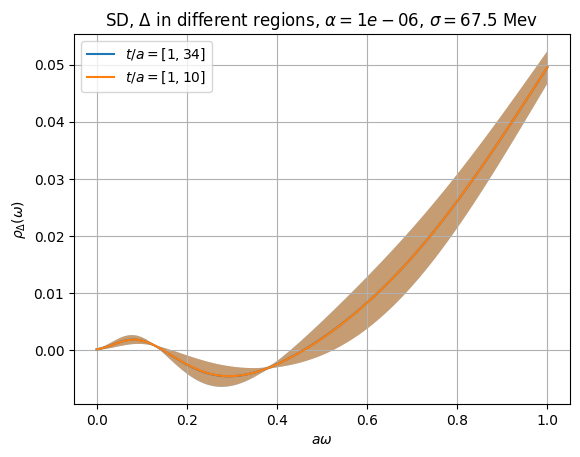

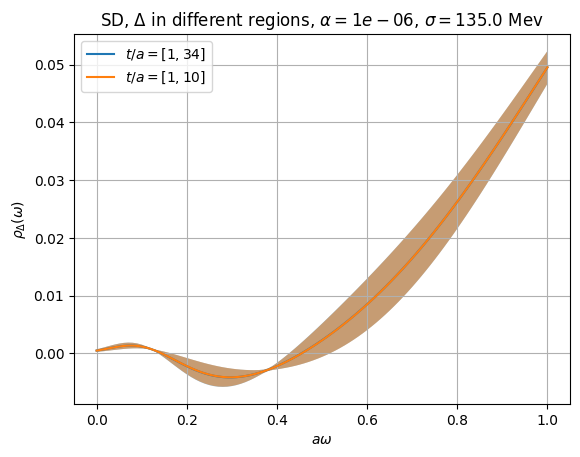

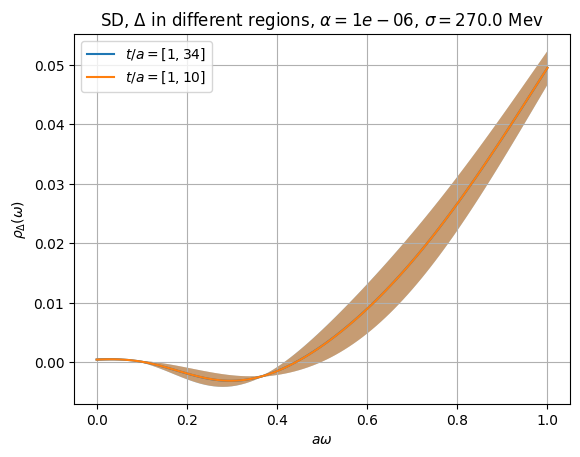

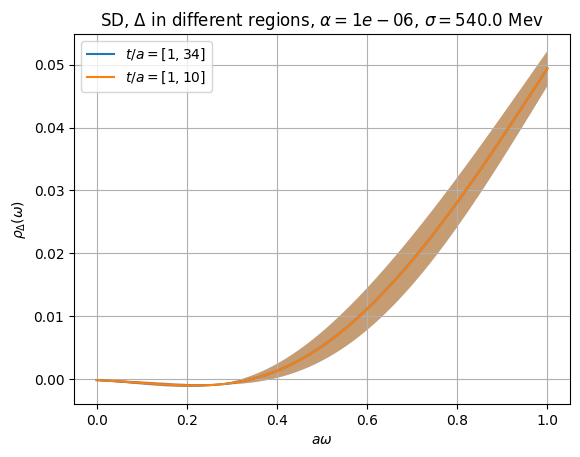

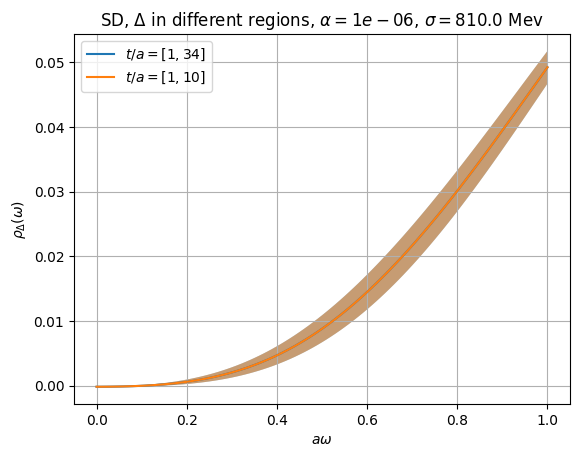

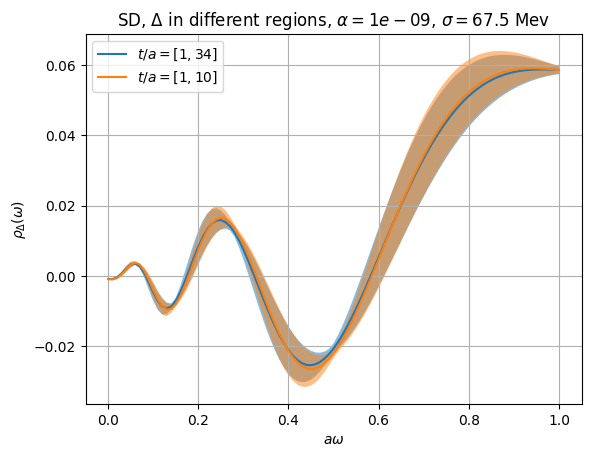

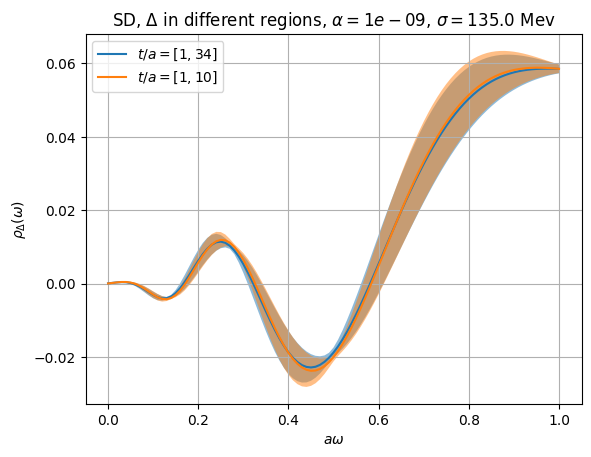

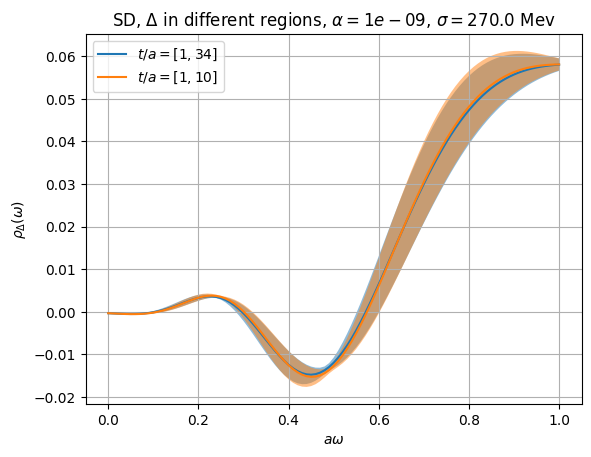

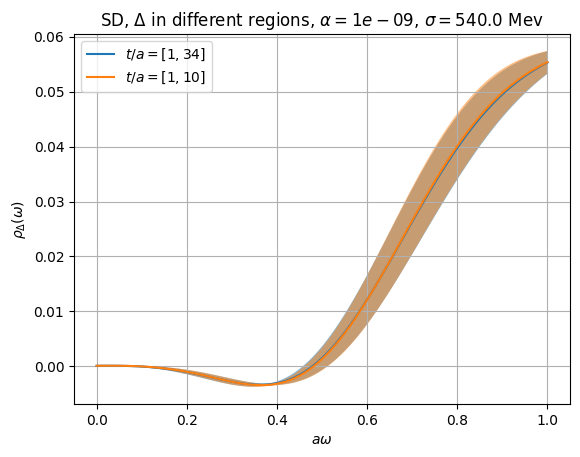

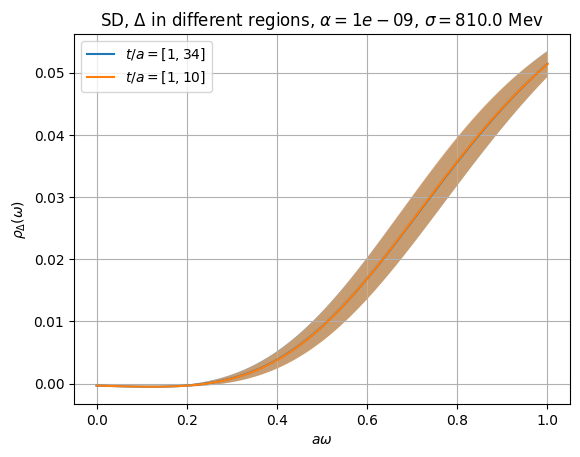

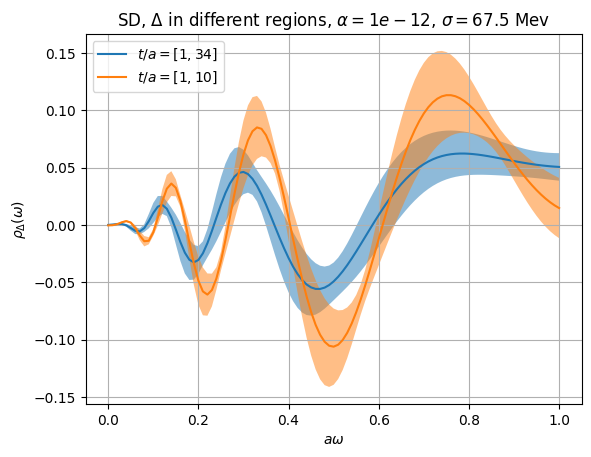

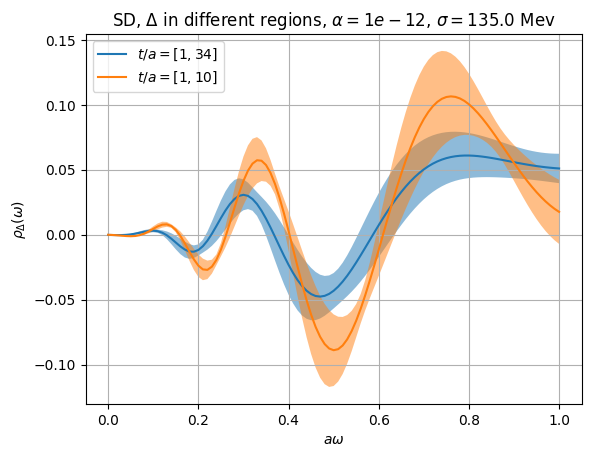

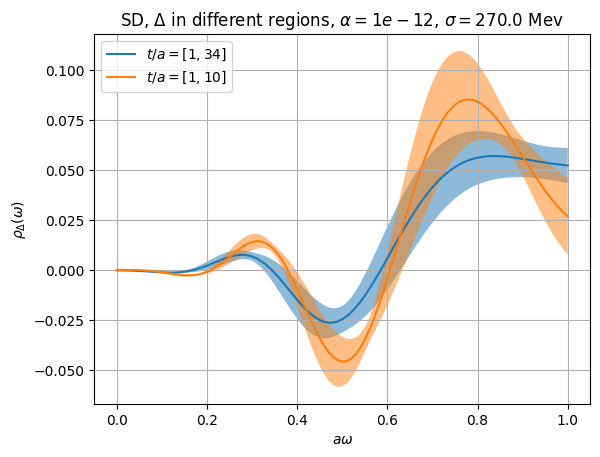

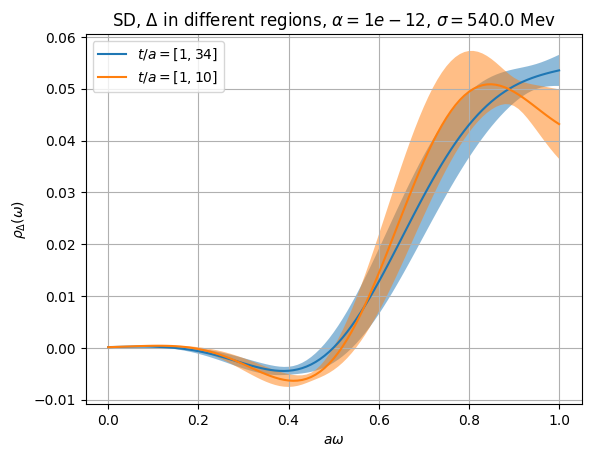

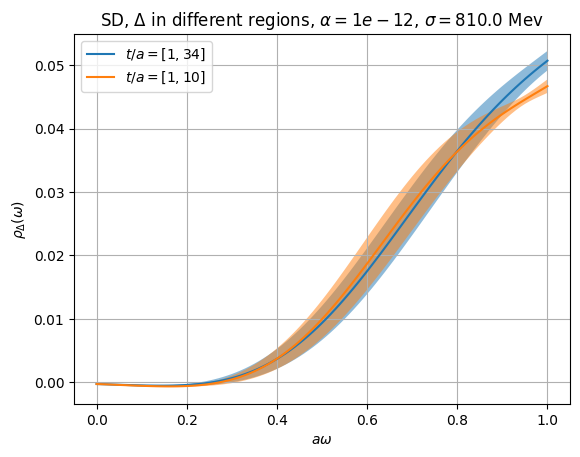

In [10]:
alpha = [1e-6, 1e-9, 1e-12]
sigma = np.array([0.25, 0.5, 1.0, 2.0, 3.0]) * 270 * 0.065 /197.3
w1 = np.linspace(0, 1, scan)

for a in range(len(alpha)):
    for s in range(len(sigma)):
        de = np.zeros(scan)
        plt.plot(w1, rho[a, s, :], label = r"$t/a = [1, 34]$")
        plt.plot(w1, rho_tr[a, s, :], label = r"$t/a = [1, 10]$")
        plt.fill_between(w1, rho[a, s, :] - rho_err[a, s, :], rho[a, s, :] + rho_err[a, s, :], alpha = 0.5)
        plt.fill_between(w1, rho_tr[a, s, :] - rho_err_tr[a, s, :], rho_tr[a, s, :] + rho_err_tr[a, s, :], alpha = 0.5)
        plt.grid()
        plt.legend()
        plt.title(r"SD, $\Delta$ in different regions, $\alpha = {}$, $\sigma = {}$ Mev".format(alpha[a], sigma[s] * 197.3 / 0.065))
        plt.xlabel(r"$a\omega$")
        plt.ylabel(r"$\rho_\Delta(\omega)$")
        plt.show()

We see a difference for relatively small values of $\alpha$. I think that this is due to the truncation error introduced by inverting a matrix with high $t_\mathrm{max}$ but using such a short correlator.

## Propagating manually the errors from the parameters

### Computation of the difference between data and the fit

We can propagate the error if we know the covariance between the parameters of the fit and the original data. Using the formulae in the reference 2209.14188 (Bruno M., Sommer R.), it can be written as:
$$ \mathrm{Cov}_\mathrm{p, d}^{\alpha, t} = [H^{-1}W^2]^{\alpha, r}\,\mathrm{Cov}_\mathrm{d}^{r, t}, $$
where $r$ is in the region of fit, and the sum over $r$ is understood. Now, if $J^{\alpha, t}$ is the jacobian of the model with respect to the parameters, we can compute the covariance between the extrapolated points and the original ones as $\mathrm{Cov}_\mathrm{e, d} = J^T \mathrm{Cov}_\mathrm{p, d} $. The covariance between the points of the difference is then:
$$ \mathrm{Cov}_\mathrm{\Delta} = \mathrm{Cov}_\mathrm{d} + \mathrm{Cov}_\mathrm{e} -2\mathrm{Cov}_\mathrm{e, d}. $$

In [8]:
df = open("out/vector/data/correlators/run_vector_folded_ml_4.txt", "r")
jf = open("out/vector/data/correlators/run_vector_jack.txt", "r")

dat = df.readlines()

corr_jack = []

for line in dat:
    jack = np.zeros(25)
    for i in range(25):
        jack[i]  = float(jf.readline())
    corr_jack.append(Jackknife())
    corr_jack[-1].mean = float((line.split())[0])
    corr_jack[-1].jack = jack

corr, err_corr, cov_corr = Jackknife.to_lists(corr_jack)
        
df.close()
jf.close()

In [9]:
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 10:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("out/vector/data/fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

In [10]:
d = Double_exp()
diff_m = np.zeros(len(corr))
for i in range(len(corr)):
    diff_m[i] = float(corr[i] - d.f(i, par))
diff_m = diff_m[1:]

cf = Corr_fits(d.f, d.der_list(), par, np.arange(10, 35), corr[10:35], cov_corr[10:35, 10:35])
Cpd = cf.cov_par_data(cov_corr[10:35, :])

J = np.zeros((len(par), len(corr)))
for i in range(len(corr)):
    J[:, i] = np.array(d.jac(i, par).tolist(), dtype = float).reshape((4,))

cov_or_fit = J.T @ Cpd

diff_cov = (cov_corr + (J.T @ cov @ J) - 2 * cov_or_fit)[1:, 1:]
diff_err = np.sqrt(np.diagonal(diff_cov))

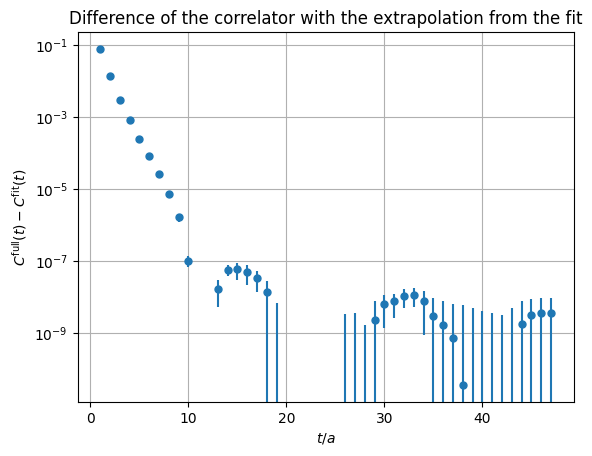

In [11]:
plt.errorbar(np.arange(1, len(diff_m[:]) + 1), diff_m[:], diff_err[:], fmt="o", markersize = 5)
plt.semilogy()
plt.grid()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$C^\mathrm{full}(t) - C^\mathrm{fit}(t)$")
plt.title("Difference of the correlator with the extrapolation from the fit")
plt.show()

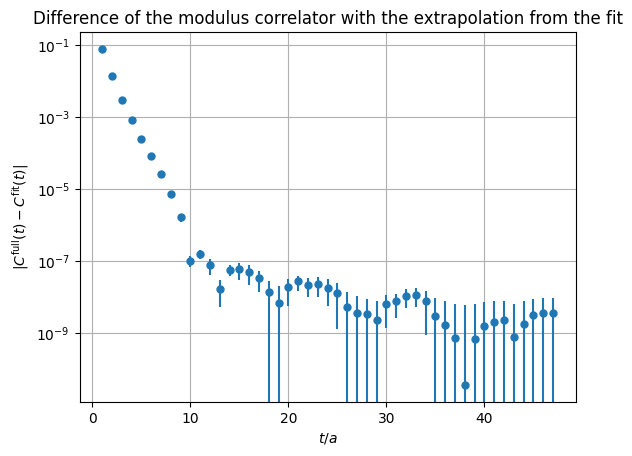

In [12]:
plt.errorbar(np.arange(1, len(diff_m[:]) + 1), np.abs(diff_m[:]), diff_err[:], fmt="o", markersize = 5)
plt.semilogy()
plt.grid()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$|C^\mathrm{full}(t) - C^\mathrm{fit}(t)|$")
plt.title("Difference of the modulus correlator with the extrapolation from the fit")
plt.show()

### ILT of the difference

Now we perform the inverse Laplace transform using the numerical method. We will try both using the difference with the length of the full correlator and using only the points in the region before the double exponential fit. To compute the error on the difference between the spectral density from the full correlator and fitted one we use a formula similar to the one used to compute the error on the difference between the correlators, but in this case the covariance matrix between the two $\rho$ is given by:
$$ \mathrm{Cov}_\mathrm{fit, full}(\omega) = g^T(\omega)\, \mathrm{Cov}_\mathrm{e, d}\, g(\omega), $$
so the error on the difference between the spectral densities is:
$$ \sigma_\Delta^2(\omega) = g^T(\omega)\, \mathrm{Cov}_\mathrm{e}\, g(\omega) + g^T(\omega)\, \mathrm{Cov_\mathrm{d}}\, g(\omega) - 2 \mathrm{Cov}_\mathrm{fit, full}(\omega) $$

In [28]:
alpha = [1e-6, 1e-9, 1e-12]
sigma = np.array([0.25, 0.5, 1.0, 2.0, 3.0]) * 270 * 0.065 /197.3
t_max = 1000
w0 = 0.0
scan = 51
w1 = np.linspace(0, 1, scan)

rho = np.zeros((len(alpha), len(sigma), len(w1)))
rho_err = np.zeros((len(alpha), len(sigma), len(w1)))
rho_tr = np.zeros((len(alpha), len(sigma), len(w1)))
rho_err_tr = np.zeros((len(alpha), len(sigma), len(w1)))

for a in range(len(alpha)):
    for s in range(len(sigma)):
        for w in range(len(w1)):
            r = SDnum_np(t_max, w0, alpha[a], w1[w], sigma[s])
            rho[a, s, w] = r.rho(diff_m[0:34])
            rho_err[a, s, w] = r.err_rho(diff_cov[0:34, 0:34])
            rho_tr[a, s, w] = r.rho(diff_m[0:10])
            rho_err_tr[a, s, w] = r.err_rho(diff_cov[0:10, 0:10])

In [19]:
x_grid = np.linspace(0.0, 1.0, scan)
r_fit_48 = np.zeros((len(alpha), len(sigma), scan))
r_fit_err_48 = np.zeros((len(alpha), len(sigma), scan))
r_full_48 = np.zeros((len(alpha), len(sigma), scan))
r_full_err_48 = np.zeros((len(alpha), len(sigma), scan))
r_an = np.zeros((len(alpha), len(sigma), scan))
r_an_err = np.zeros((len(alpha), len(sigma), scan))

r_fit_34 = np.zeros((len(alpha), len(sigma), scan))
r_fit_err_34 = np.zeros((len(alpha), len(sigma), scan))
r_full_34 = np.zeros((len(alpha), len(sigma), scan))
r_full_err_34 = np.zeros((len(alpha), len(sigma), scan))

out = open("out/vector/data/rho/dsp.txt")
for a in range(len(alpha)):
    for s in range(len(sigma)):
        for w in range(scan):
            l = out.readline()
            r_fit_34[a, s, w], r_fit_err_34[a, s, w] = l.split()[0], l.split()[1]
            l = out.readline()
            r_fit_48[a, s, w], r_fit_err_48[a, s, w] = l.split()[0], l.split()[1]
            l = out.readline()
            r_full_34[a, s, w], r_full_err_34[a, s, w] = l.split()[0], l.split()[1]
            l = out.readline()
            r_full_48[a, s, w], r_full_err_48[a, s, w] = l.split()[0], l.split()[1]
            l = out.readline()
            r_an[a, s, w], r_an_err[a, s, w] = l.split()[0], l.split()[1]
out.close()

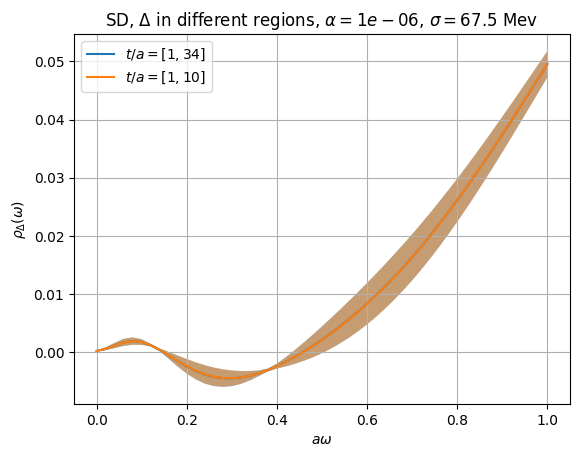

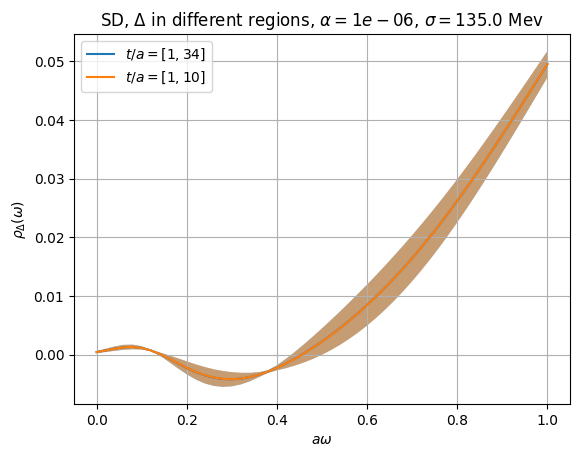

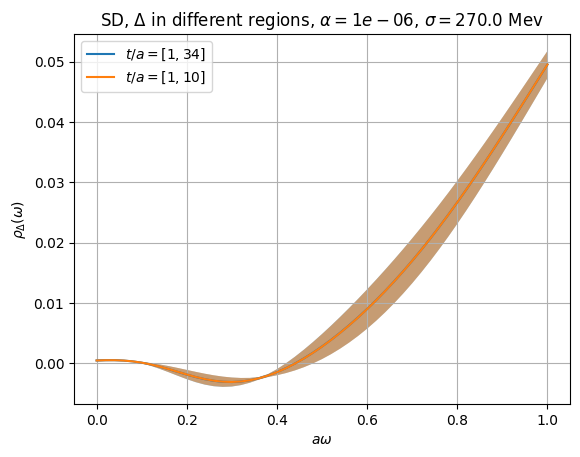

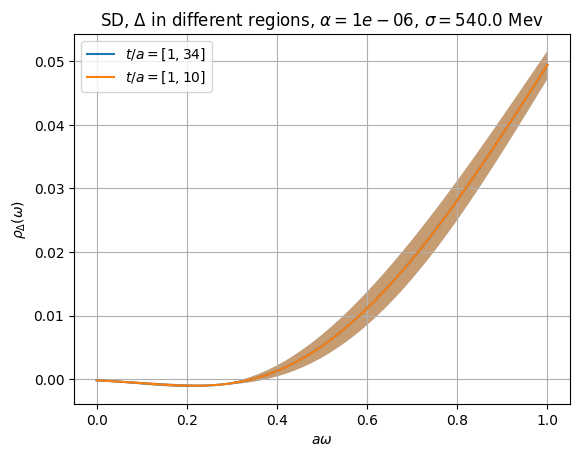

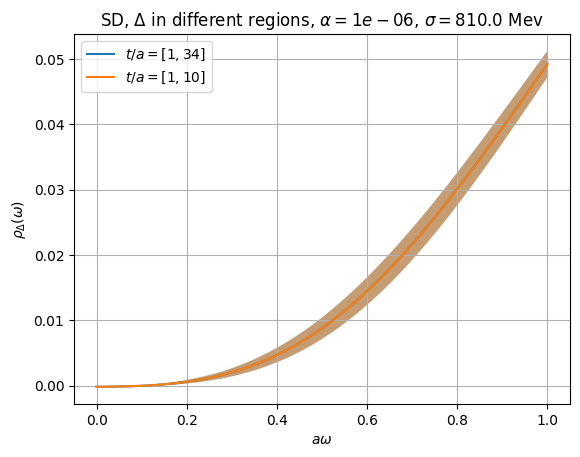

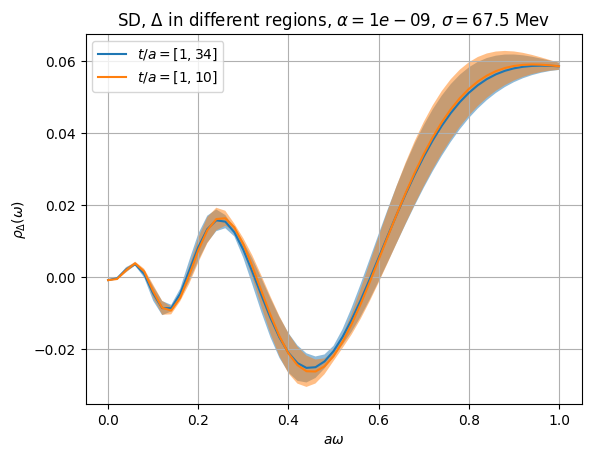

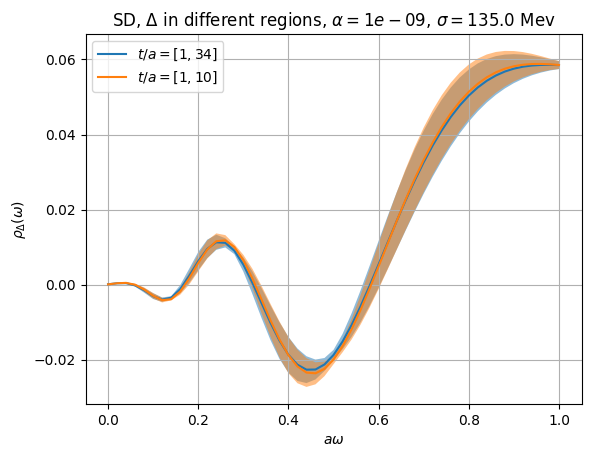

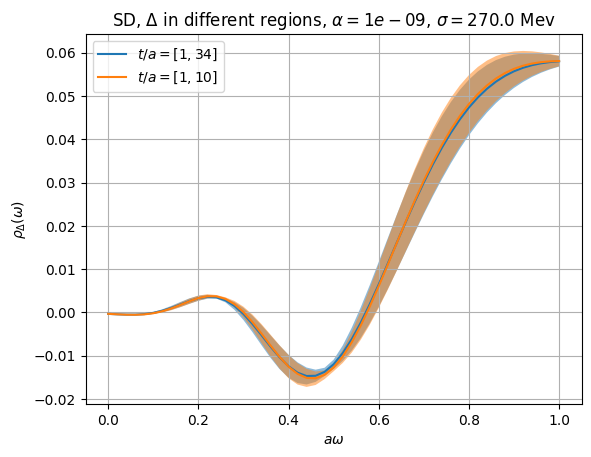

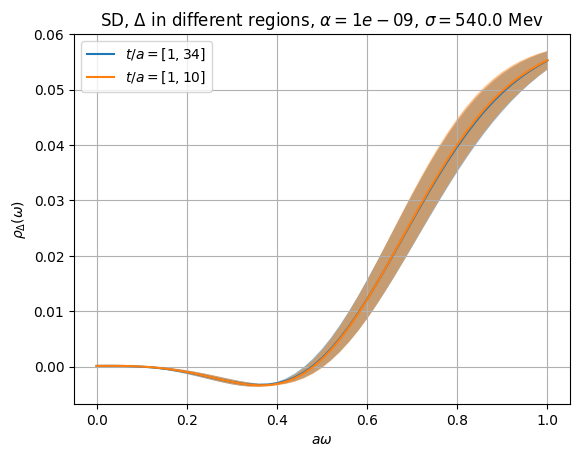

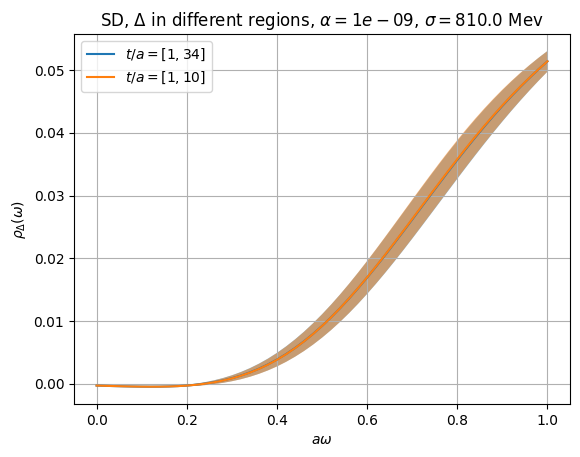

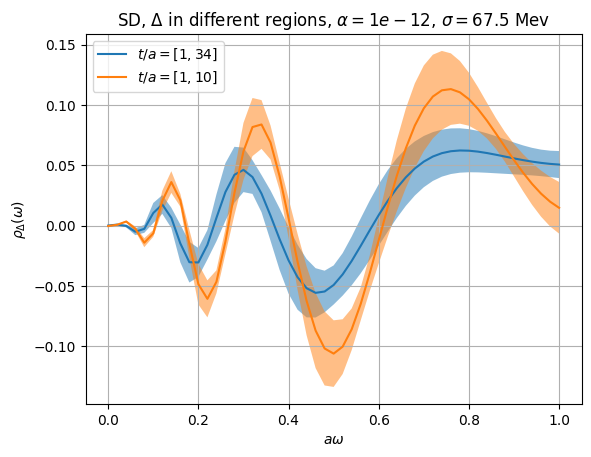

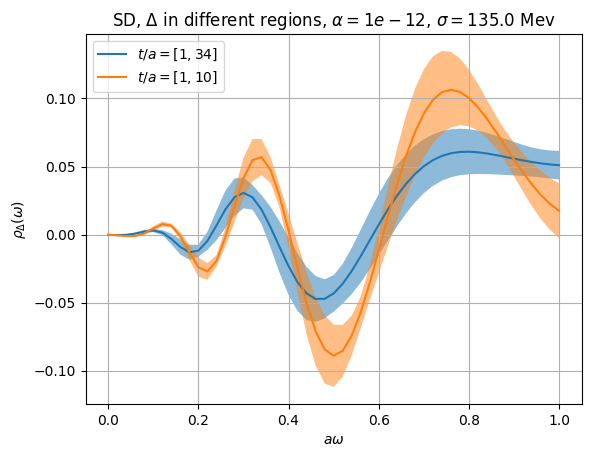

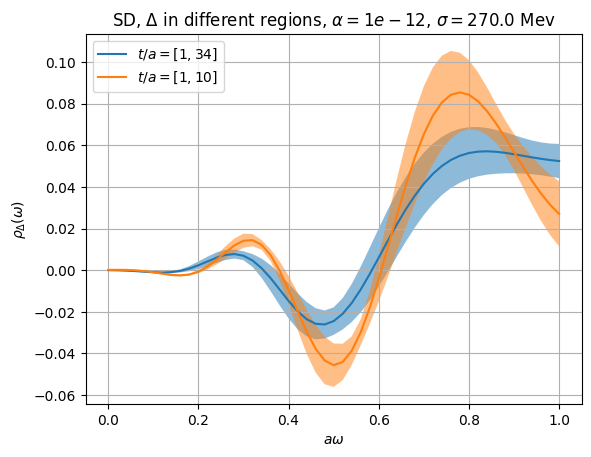

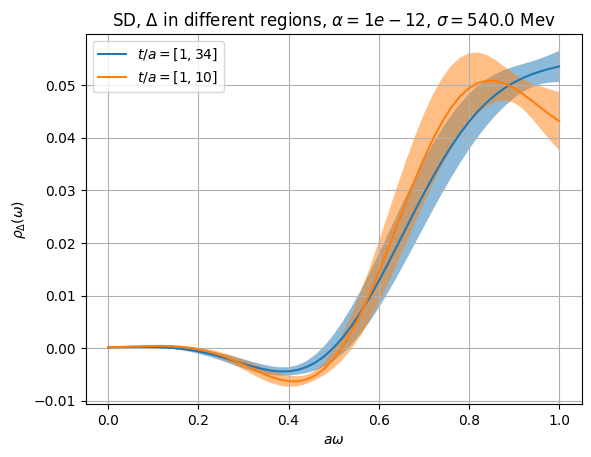

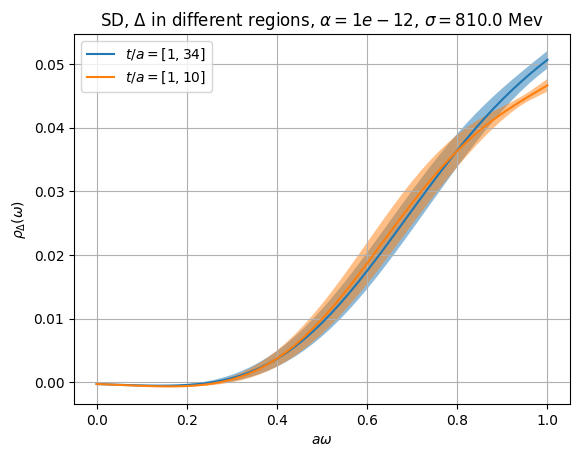

In [30]:
alpha = [1e-6, 1e-9, 1e-12]
sigma = np.array([0.25, 0.5, 1.0, 2.0, 3.0]) * 270 * 0.065 /197.3
w1 = np.linspace(0, 1, scan)

cf = Corr_fits(d.f, d.der_list(), par, np.arange(10, 35), corr[10:35], cov_corr[10:35, 10:35])
Cpd = cf.cov_par_data(cov_corr[10:35, :])

for a in range(len(alpha)):
    for s in range(len(sigma)):
        de = np.zeros(scan)
        plt.plot(w1, rho[a, s, :], label = r"$t/a = [1, 34]$")
        plt.plot(w1, rho_tr[a, s, :], label = r"$t/a = [1, 10]$")
        plt.fill_between(w1, rho[a, s, :] - rho_err[a, s, :], rho[a, s, :] + rho_err[a, s, :], alpha = 0.5)
        plt.fill_between(w1, rho_tr[a, s, :] - rho_err_tr[a, s, :], rho_tr[a, s, :] + rho_err_tr[a, s, :], alpha = 0.5)
        plt.grid()
        plt.legend()
        plt.title(r"SD, $\Delta$ in different regions, $\alpha = {}$, $\sigma = {}$ Mev".format(alpha[a], sigma[s] * 197.3 / 0.065))
        plt.xlabel(r"$a\omega$")
        plt.ylabel(r"$\rho_\Delta(\omega)$")
        plt.show()

We can observe an important difference between using the full $\Delta$ vs using it only in the region outside the fit. Shortening the correlator worsen the problem of truncating the $\vec g$ coefficients, enhancing it also at relatively high values of $\alpha$. In my opinion, it is better to keep the full difference.

# Mellin transform integral

The relation between the Laplace trasform and the Mellin transform and the fact that the correlator is the inverse Laplace transform of the spectral density allow to find a relation also between the Mellin transform of the correlator and the Mellin transform of the spectral density.

We begin by defining the Mellin transform:
$$ \tilde{f}(z) = \int_0^{+\infty}dt\, t^{z-1} f(t). $$
Considering that $ C(t) = \int_0^{+\infty}d\omega\, \rho(\omega)\omega^n e^{-\omega t} $ for a generic subtracted spectral density, we can derive the following expression:
$$ \begin{align}
  \tilde{C}(z)&= \int_0^{+\infty}dt\, C(t) = \int_0^{+\infty}d\omega\,\omega^n\rho(\omega)\int_0^{+\infty}dt\, e^{-\omega t}t^{z-1} = \\
              &= \Gamma(z)\int_0^{+\infty} d\omega \, \omega^{n-z}\rho(\omega) = \Gamma(z) \tilde{\rho}(n+1-z).
\end{align}$$
We can also write, using the Mellin basis:
$$ \int_0^{+\infty}dt\,C(t) t^n u_s(t) = \frac{1}{\sqrt{2\pi}} \tilde{C}(n+1/2+is) = \frac{1}{\sqrt{2\pi}}\Gamma(n+1/2+is)\tilde{\rho}(1/2-is). $$
To obtain $\rho(\omega)$, we can apply an inverse Mellin transform:
$$ \rho(\omega) = \frac{1}{2\pi}\int_{c-i\infty}^{c+i\infty}dz\, \omega^{-z}\tilde{\rho}(z) = \frac{1}{2\pi}\int_{-\infty}^{+\infty}ds\, \omega^{-1/2 + is} \tilde{\rho}(1/2-is) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{+\infty}ds\, \frac{\tilde{C}(n+1/2+is)}{\Gamma(n+1/2+is)}u_s(\omega) $$
We need to be sure that the Mellin transform of the correlator is well defined for $\mathrm{Re}\{z\} = n + 1/2$ and that the inverse Mellin trasform is also convergent.

## Mellin trasform of the double exponential


We want to study the Mellin transform of the infrared part of the correlator extracted with the fit with the double exponential. First, we consider the Mellin transform evaluated at the point needed to extract the spectral density:
$$ \tilde{C_2}(n, s) = \frac{1}{\sqrt{2\pi}}\tilde{C}(n + 1/2 + is) = \int_0^{+\infty}dt\,C(t) t^n u_s(t), \quad u_s(t) = \frac{t^{-1/2 + is}}{\sqrt{2\pi}}. $$
Since we have that:
$$ I_n(\omega, s) = (\widetilde{e^{-\omega t}})(n + 1/2 + is) =  \Gamma(n + 1/2 +is)\omega^{-n} u_s^*(\omega), $$
the Mellin transform of the double exponential is:
$$ C_2(t) = c_0 e^{-m_0t} + c_1 e^{-m_1 t} \implies \tilde{C_2}(n, s) = c_0 I_n(m_0, s) + c_1 I_n(m_1, s). $$
In our case (vector current), $n = 2$.

To propagate the error, we compute the jacobian:
$$\begin{align}J &= \biggl(\frac{\partial\tilde{C_2}}{\partial c_0}, \frac{\partial\tilde{C_2}}{\partial m_0}, \frac{\partial\tilde{C_2}}{\partial c_1}, \frac{\partial\tilde{C_2}}{\partial m_1}\biggr) \\
\frac{\partial\tilde{C_2}}{\partial c_0} &= I_n(m_0, s) \\
\frac{\partial\tilde{C_2}}{\partial m_0} &= c_0\Bigl(\frac{\partial I_n}{\partial m_0}\Bigr) \\
\frac{\partial\tilde{C_2}}{\partial c_1} &= I_n(m_0, s) \\
\frac{\partial\tilde{C_2}}{\partial m_1} &= c_1\Bigl(\frac{\partial I_n}{\partial m_1}\Bigr) 
\end{align}$$
and:
$$ \frac{\partial I_n}{\partial \omega} = -(n+1/2+is)I_{n+1}(\omega, s).  $$
To compute the error on the real (imaginary) part of the Mellin transform, it is sufficient to consider the real (imaginary) part of $J$ in the product $J^T\, \mathrm{Cov}\, J$.

In [14]:
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 10:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("out/vector/data/fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

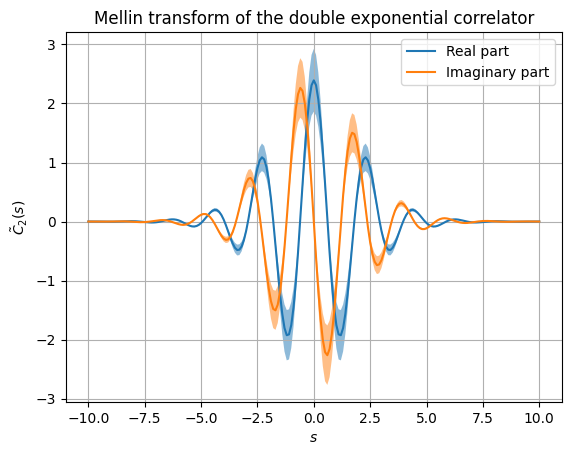

In [15]:
n_vect = 4
x = np.linspace(-10, 10, 201)
re, re_err = mellin_C2(x, par, n_vect).real, np.sqrt(np.diagonal(jac_mellinC2(x, par, n_vect).T.real @ cov @ jac_mellinC2(x, par, n_vect).real))
im, im_err = mellin_C2(x, par, n_vect).imag, np.sqrt(np.diagonal(jac_mellinC2(x, par, n_vect).T.imag @ cov @ jac_mellinC2(x, par, n_vect).imag))
plt.plot(x, re, label = "Real part")
plt.fill_between(x, re - re_err, re + re_err, alpha = 0.5)
plt.plot(x, mellin_C2(x, par, n_vect).imag, label = "Imaginary part")
plt.fill_between(x, im - im_err, im + im_err, alpha = 0.5)
plt.legend()
plt.grid()
plt.xlabel(r"$s$")
plt.ylabel(r"$\tilde{C}_2(s)$")
plt.title("Mellin transform of the double exponential correlator")
plt.show()

If we are considering the modulus of the Mellin transform, the propagation of the error is given by noting that the jacobian in this case can be written in terms of the jacobian of the Mellin transform:
$$ \frac{\partial |\tilde{C_2}|^2}{\partial p_i} = 2 \biggl(\mathrm{Re}\{\tilde{C_2}\}\mathrm{Re}\biggl\{\frac{\partial \tilde{C_2}}{\partial p_i}\biggr\} + \mathrm{Im}\{\tilde{C_2}\}\mathrm{Im}\biggl\{\frac{\partial \tilde{C_2}}{\partial p_i}\biggr\}\biggr)$$

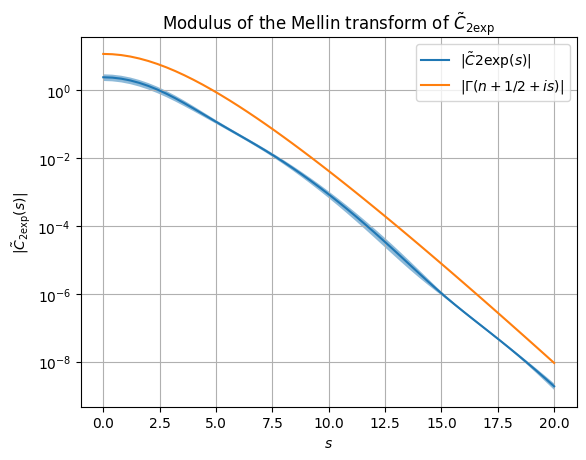

In [16]:
n_vect = 4
x = np.linspace(0, 20, 51)
mod, mod_err = mod_mellinC2(x, par, n_vect), np.sqrt(np.diag(jac_modmellinC2(x, par, n_vect).T @ cov @ jac_modmellinC2(x, par, n_vect)))
plt.plot(x, mod, label = r"$|\tilde{C}\mathrm{2exp}(s)|$")
plt.fill_between(x, mod - mod_err, mod + mod_err, alpha = 0.5)
plt.plot(x, np.abs(gamma(n_vect + 0.5 + x *1.0j)), label = r"$|\Gamma(n+1/2+is)|$")
plt.grid()
plt.legend()
plt.semilogy()
plt.xlabel(r"$s$")
plt.ylabel(r"$|\tilde{C}_\mathrm{2exp}(s)|$")
plt.title(r"Modulus of the Mellin transform of $\tilde{C}_\mathrm{2exp}$")
plt.show()

## Mellin transform of the difference

We now want to study the Mellin trasform of the difference. Since at the moment there is no a formula that allows to compute it from discrete, finite data, we decide to interpolate the difference using a polinomial, and then compute the Mellin trasform.

### Interpolation of the difference

#### Attempts of fit (failed)

In [11]:
def func_fit(x, a, b, c, d):
    return np.exp(-a*x)*(b + c/(x+d)**3.)

par_sub, _ = curve_fit(func_fit, np.arange(0, 10), diff_m[0:10], p0 = [2.0, 0.7, 1.2, 1.8], sigma=diff_err[0:10])
plt.errorbar(range(len(diff_m)), diff_m, diff_err, fmt="o", markersize = 5)
plt.semilogy()
plt.xlim([-0.5, 9.5])
plt.grid()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$C^\mathrm{full}(t) - C^\mathrm{fit}(t)$")
plt.plot(np.linspace(0, 10, 50), func_fit(np.linspace(0, 10, 50), par_sub[0], par_sub[1], par_sub[2], par_sub[3]))
print(par_sub)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [31]:
par_sub_jack = Jackknife.fit(func_fit, np.arange(1, 10), diff_jack[1:10], p_init = [2.0, 0.7, 1.2, 1.8])
print(Jackknife.to_lists(par_sub_jack)[0])
print(Jackknife.to_lists(par_sub_jack)[2])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [8]:
def func(x, par):
    return func_fit(x, par[0], par[1], par[2], par[3])

def der():
    return [lambda x, par: -x*func(x, par), lambda x, par: np.exp(-par[0] * x),\
             lambda x, par: np.exp(-par[0] * x)/(x+par[3])**3.0, lambda x, par: -3.*np.exp(-par[0]*x)*par[2]/(x+par[3])**4.0] 

p = Corr_fits(func, der(), par_sub, np.arange(1, 9), diff_m[1:9], diff_cov[1:9, 1:9])
print(p.p_val(100000)*100)

0.0


#### Interpolating the log(diff)

We want to interpolate the the logarithm of the difference between the correlator and the fit between $t/a = 1$ and $t/a = 10$ in order to compute its Mellin transform. In particular, calling $D(t)$ the interpolation, we want to compute $\tilde{D}(n+1/2+is)/\sqrt{2\pi} $ (which is well defined, since we integrate over a compact intervall), to study the the integrand of the spectral density formula in terms of the inverse Mellin transform.

The interpolation is given by, calling $L_i = \log(\Delta_i)$, $i = 1, \dots, 10$:
$$ D(t) = \exp [L_i (1 + i - t) + L_{i+1}(t-i)],\quad t \in [i, i+1],\quad i = 1, \dots, 9.  $$
Its jacobian is:
$$ J(t)_j = \frac{\partial D(t)}{\partial L_j} = D(t)[\delta_{ij}(1+i-t) + \delta_{i+1, j}(t-i)],\quad t \in [i, i+1],\quad i = 1, \dots, 9,$$
so the error is $\sigma_D^2(t) = J^T(t)\, \mathrm{Cov}_{L_i}\, J(t)$.

Then we want to compute the Mellin transform. The integral can be cast in the following form:
$$\begin{align}
&\tilde{D}(n+1/2+is)/\sqrt{2\pi} = \sum_{i = 1}^9\int_i^{i+1}dt\, e^{L_i (1 + i - t) + L_{i+1}(t-i)} t^n u_s(t) = \\
&= \frac{1}{\sqrt{2\pi}} \sum_{i = 1}^9 e^{L_i(1+i) - L_{i+1} i}\, (L_i - L_{i+1})^{-(n+1/2+is)}\,\Gamma(n+1/2+is, (L_i - L_{i+1})i, (L_i - L_{i+1})(i+1))
\end{align}$$

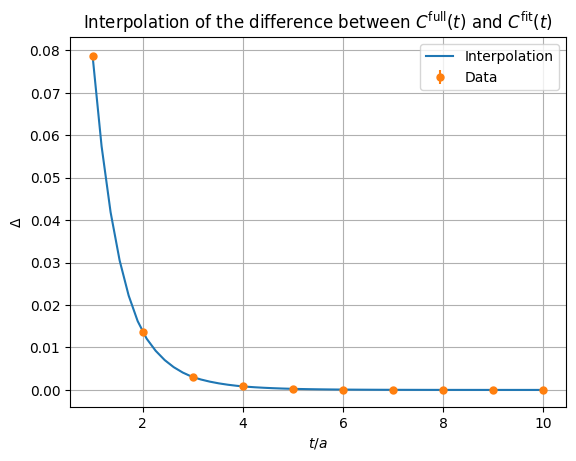

In [17]:
log_m = np.log(diff_m[0:10])
log_cov = np.zeros(diff_cov[0:10, 0:10].shape)
for i in range(len(diff_m[0:10])):
    for j in range(len(diff_m[0:10])):
        log_cov[i, j] = diff_cov[i, j]/(diff_m[i] * diff_m[j])

x = np.linspace(1, 9.999, 51)
y, y_err = [], []
for xi in x:
    y.append(interp(xi, log_m))
    y_err.append(np.sqrt(interp_cov(xi, xi, log_m, log_cov)))

plt.plot(x, y, label = "Interpolation")
plt.errorbar(np.arange(1, 11), diff_m[0:10], diff_err[0:10], fmt="o", markersize = 5, label = "Data")
plt.fill_between(x, np.array(y)-np.array(y_err), np.array(y)+ np.array(y_err), alpha = 0.5)

plt.grid()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$\Delta$")
plt.legend()
plt.title(r"Interpolation of the difference between $C^\mathrm{full}(t)$ and $C^\mathrm{fit}(t)$")
plt.show()

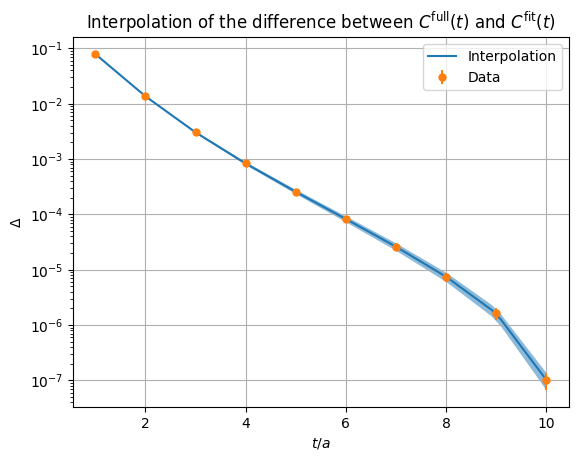

In [18]:
log_m = np.log(diff_m[0:10])
log_cov = np.zeros(diff_cov[0:10, 0:10].shape)
for i in range(len(diff_m[0:10])):
    for j in range(len(diff_m[0:10])):
        log_cov[i, j] = diff_cov[i, j]/(diff_m[i] * diff_m[j])

x = np.linspace(1, 9.999, 51)
y, y_err = [], []
for xi in x:
    y.append(interp(xi, log_m))
    y_err.append(np.sqrt(interp_cov(xi, xi, log_m, log_cov)))

plt.plot(x, y, label = "Interpolation")
plt.errorbar(np.arange(1, 11), diff_m[0:10], diff_err[0:10], fmt="o", markersize = 5, label = "Data")
plt.fill_between(x, np.array(y)-np.array(y_err), np.array(y)+ np.array(y_err), alpha = 0.5)

plt.grid()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$\Delta$")
plt.legend()
plt.semilogy()
plt.title(r"Interpolation of the difference between $C^\mathrm{full}(t)$ and $C^\mathrm{fit}(t)$")
plt.show()

### The Mellin trasform of the difference

In [19]:
n_vect = 2
x = np.linspace(-10, 10, 101)
y_re_err, y_im_err = [], []
r = mellin_diff(x, n_vect, log_m)
y_re, y_im = r.real, r.imag
j = jac_mellindiff(x, n_vect, log_m)
y_re_err, y_im_err = np.sqrt(np.diagonal(j.real.T @ log_cov @ j.real)), np.sqrt(np.diagonal(j.imag.T @ log_cov @ j.imag))

Text(0, 0.5, '$\\tilde{D}(s)$')

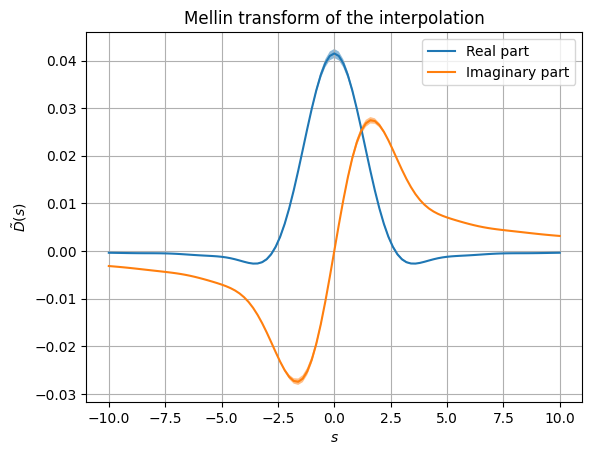

In [20]:
plt.plot(x, y_re, label = "Real part")
plt.fill_between(x, y_re - y_re_err, y_re + y_re_err, alpha=0.5)
plt.plot(x, y_im, label = "Imaginary part")
plt.fill_between(x, y_im - y_im_err, y_im + y_im_err, alpha=0.5)
plt.grid()
plt.legend()
plt.title("Mellin transform of the interpolation")
plt.xlabel(r"$s$")
plt.ylabel(r"$\tilde{D}(s)$")

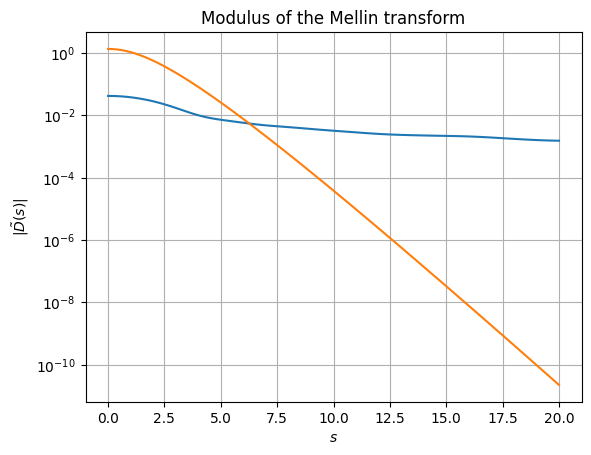

In [21]:
x = np.linspace(0, 20, 101)
y = mod_mellindiff(x, n_vect, log_m)
J = jac_modmellindiff(x, n_vect, log_m)
y_err = np.sqrt(np.diagonal(J.T @ log_cov @ J))

plt.plot(x, y)
plt.fill_between(x, y-y_err, y + y_err, alpha = 0.5)
plt.plot(x, np.abs(gamma(n_vect + 0.5 + x *1.0j)))
plt.semilogy()
plt.grid()
plt.xlabel(r"$s$")
plt.ylabel(r"$|\tilde{D}(s)|$")
plt.title("Modulus of the Mellin transform")
plt.show()

### $\rho$ from the inverse Mellin transform

Now we want to study the integrand of the inverse Mellin transform to understand its behaviour at $s \rightarrow \pm \infty$. We begin from looking at 
$$r(s) = \tilde{C}(n+1/2+is)/\Gamma(n+1/2+is).$$
The denominator decays exponentially when $s \rightarrow \pm \infty$, so we need a delicate cancellation from the Mellin transform of the correlator in order to get a sufficiently convergent integrand.

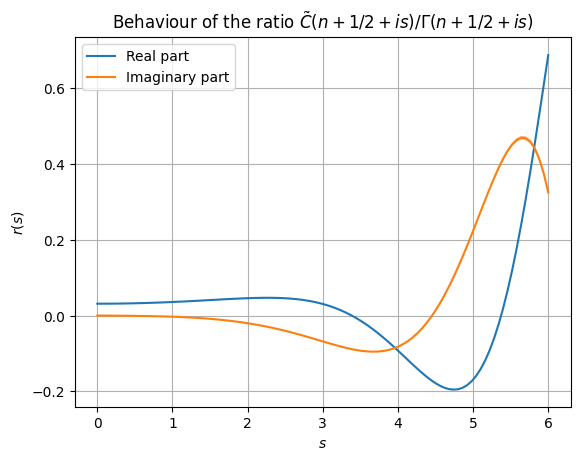

In [64]:
x = np.linspace(0, 6, 101)
y = (mellin_diff(x, n_vect, log_m)/gamma(n_vect + 0.5 + x*1.0j))
j = jac_mellindiff(x, n_vect, log_m)/gamma(n_vect + 0.5 + x*1.0j)
y1, y1_err = y.real, np.sqrt(np.diagonal(j.real.T @ log_cov @ j.real))
y2, y2_err = y.imag, np.sqrt(np.diagonal(j.imag.T @ log_cov @ j.imag))
plt.plot(x, y1, label = "Real part")
plt.fill_between(x, y1 - y1_err, y1 + y1_err, alpha = 0.5)
plt.plot(x, y2, label = "Imaginary part")
plt.fill_between(x, y2 - y2_err, y2 + y2_err, alpha = 0.5)
plt.grid()
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$r(s)$")
plt.title(r"Behaviour of the ratio $\tilde{C}(n+1/2+is)/\Gamma(n+1/2+is)$")
plt.show()

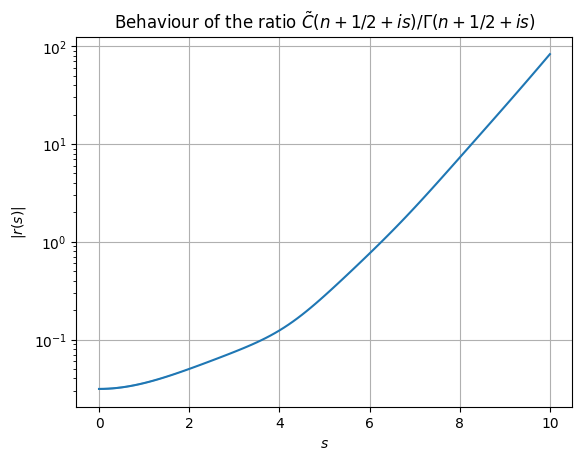

In [66]:
x = np.linspace(0, 10, 101)
den = np.sqrt((gamma(n_vect + 0.5 + x*1.0j).real ** 2.0 + gamma(n_vect + 0.5 + x*1.0j).imag ** 2.0))
y = (mod_mellindiff(x, n_vect, log_m)/den)
j = jac_modmellindiff(x, n_vect, log_m)/den
y_err = np.sqrt(np.diagonal(j.T @ log_cov @ j))
plt.plot(x, y)
plt.fill_between(x, y - y_err, y + y_err, alpha = 0.5)
plt.grid()
plt.xlabel(r"$s$")
plt.ylabel(r"$|r(s)|$")
plt.title(r"Behaviour of the ratio $\tilde{C}(n+1/2+is)/\Gamma(n+1/2+is)$")
plt.semilogy()
plt.show()

#### Tikhonov regularisation

Let's see what happens if we regulate the inverse Mellin trasform a-là Tikhonov, making the substitution:
$$ \frac{1}{\Gamma(n+1/2+is)} \rightarrow \frac{\Gamma^*(n+1/2+is)}{|\Gamma(n+1/2+is)|^2 + \alpha}, \quad \alpha > 0. $$
We observe that we obtain the l.h.s in the limit $\alpha \rightarrow 0$.

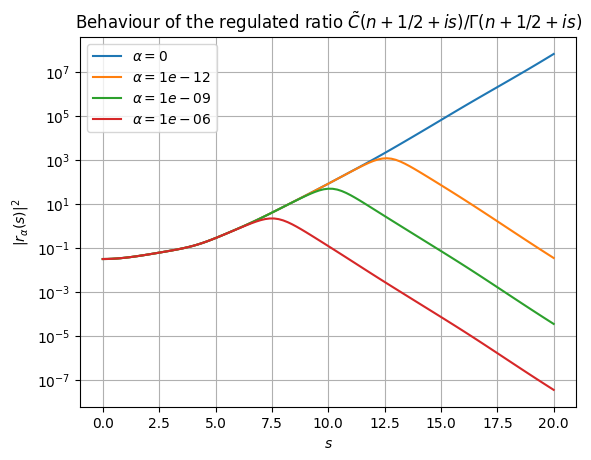

In [24]:
x = np.linspace(0, 20, 101)
alpha = [0, 1e-12, 1e-9, 1e-6]
for a in alpha:
    den_reg = (gamma(n_vect + 0.5 + x*1.0j).conjugate()/(gamma(n_vect + 0.5 + x*1.0j) * gamma(n_vect + 0.5 + x*1.0j).conjugate() + a))
    den_reg = np.sqrt(den_reg.real ** 2.0 + den_reg.imag ** 2.0)
    y = (mod_mellindiff(x, n_vect, log_m) * den_reg)
    j = jac_modmellindiff(x, n_vect, log_m) * den_reg
    y_err = np.sqrt(np.diagonal(j.T @ log_cov @ j))
    plt.plot(x, y, label = r"$\alpha = {}$".format(a))
    plt.fill_between(x, y - y_err, y + y_err, alpha = 0.5)
plt.grid()
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$|r_\alpha(s)|^2$")
plt.title(r"Behaviour of the regulated ratio $\tilde{C}(n+1/2+is)/\Gamma(n+1/2+is)$")
plt.semilogy()
plt.show()